In [1]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig,LlamaTokenizer
from huggingface_hub import notebook_login
from datasets import load_dataset
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from datetime import datetime

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [8]:
from trl import SFTTrainer, setup_chat_format
import json
from peft import PeftModel, PeftConfig,AutoPeftModelForCausalLM

def load_model_tokenizer_questions(base_model, lora_model, question_file):
    
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    model = AutoModelForCausalLM.from_pretrained(base_model, device_map="auto")
    model.resize_token_embeddings(128258)  # Or len(tokenizer) if you're using the LoRA tokenizer
    model = PeftModel.from_pretrained(model, lora_model, device_map="auto")
    

    model, tokenizer = setup_chat_format(model, tokenizer)


    
    with open(question_file, 'r', encoding='utf-8') as file:
    # with open('/home/fuxiaoqin/Downloads/EngineeringReference1_All_TESTQAGPT4omini.json', 'r', encoding='utf-8') as file:
        json_obj = json.load(file)

    # print(json_obj)
    # print(json_obj[0])
    # data_chunkis = []
    data_instructions = []
    data_inputs = []
    data_outputs = []
    for piece in json_obj:
        # print("piece", piece['input'])
        # data_chunkis.append(piece['chunki'])
        data_instructions.append(piece['instruction'])
        data_inputs.append(piece['input'])
        data_outputs.append(piece['output'])

    print(len(data_instructions))
    print(len(data_inputs))
    print(len(data_outputs))

    return model, tokenizer, data_instructions, data_inputs, data_outputs

In [9]:
model, tokenizer, data_instructions, data_inputs, data_outputs = load_model_tokenizer_questions(
    base_model="meta-llama/Llama-3.2-3B",
    lora_model="xfu20/Building_energy_Llama_3B_LoRA",
    question_file="/srv/data1/fuxiaoqin/Downloads/EngineeringReference1_5_TESTQAGPT4omini.json"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

17
17
17


In [10]:
def get_responses(data_inputs, model, tokenizer):
    responses = []
    for dp in data_inputs:
    # for i in range(21,27):
        # dp = data_inputs[i]
        messages = [
            {
                "role": "user",
                # "content": "What is the climate of a building located in west Arizona? (In a sentence)"
                "content": dp + " (In a sentence)"
            }
        ]
        
        prompt = tokenizer.apply_chat_template(messages, tokenize=False,
                                               add_generation_prompt=True)
        
        inputs = tokenizer(prompt, return_tensors='pt', padding=True,
                           truncation=True).to("cuda")
        
        outputs = model.generate(**inputs, max_length=150,
                                 num_return_sequences=1)
        
        text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        #  print(text)
        # print(text.split("assistant"))
        # print(dp +" "+text.split("assistant")[1])
        response = text.split("assistant")[1].replace("\n","").split(", ")[0].split(". ")[0].strip()+"."
        responses.append(response)
    return responses

In [11]:
lora_responses = get_responses(data_inputs, model, tokenizer)
# print(f"lora_responses = {lora_responses}")
print("len(responses) =", len(lora_responses))

len(responses) = 17


In [12]:
def save_results_csv(fileName, instructions, inputs, outputs, predictions):
    min_len = 17 # min (len(instructions), len(inputs), len(outputs), len(predictions))
    wf = open(fileName, 'w', encoding="utf8")
    wf.write("Instruction,Input,Output,Predicted\n")
    for i in range(min_len):
        wf.write(str(instructions[i])+','+str(inputs[i])+',"'+str(outputs[i])+'","'+str(predictions[i])+'"\n')
    wf.close()

In [13]:
references = data_outputs
print("len(references)", len(references))
# print("len(pretrained_responses)", len(pretrained_responses))

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from numpy import *
from rouge import Rouge
from bert_score import score

def compute_bleu(reference, hypothesis):
    reference = [reference.split()]
    hypothesis = hypothesis.split()
    smoothie = SmoothingFunction().method4
    return sentence_bleu(reference, hypothesis, smoothing_function=smoothie)

def save_metrics_csv(fileName, modelName, bleus, rouge1, rouge2, rouge3, b_r, b_p, b_f):
    bleu = mean(bleus)
    r1_r=rouge1['r']
    r1_p=rouge1['p']
    r1_f=rouge1['f']
    r2_r=rouge2['r']
    r2_p=rouge2['p']
    r2_f=rouge2['f']
    r3_r=rouge3['r']
    r3_p=rouge3['p']
    r3_f=rouge3['f']    
    b_r = str(b_r).replace("tensor(","").replace(")","")
    b_p = str(b_p).replace("tensor(","").replace(")","")
    b_f = str(b_f).replace("tensor(","").replace(")","")
    # if os.path.exists(fileName):
    #     r = open(fileName, 'a', encoding="utf8")
    #     r.write(str(modelName)+","+str(bleu)+","+str(r1_r)+","+str(r1_p)+","+str(r1_f)+","+str(r2_r)+","+str(r2_p)+","+str(r2_f)+","+str(r3_r)+","+str(r3_p)+","+str(r3_f)+","+str(b_r)+","+str(b_p)+","+str(b_f)+",\n")
    #     r.close()
    # else:
    r = open(fileName, 'w', encoding="utf8")
    r.write("Training,BLEU,ROUGE-1,,,ROUGE-2,,,ROUGE-L,,,BERT,,,Fineturning\n")
    r.write("/Testing,,r ,p,f,r ,p,f,r ,p,f,R,P,F1,Time\n")
    r.write(str(modelName)+","+str(bleu)+","+str(r1_r)+","+str(r1_p)+","+str(r1_f)+","+str(r2_r)+","+str(r2_p)+","+str(r2_f)+","+str(r3_r)+","+str(r3_p)+","+str(r3_f)+","+str(b_r)+","+str(b_p)+","+str(b_f)+",\n")
    r.close()  
        
def compute_save_metrics(references, responses, fileName, modelName):
    # BLEU scores
    bleu_scores = [compute_bleu(ref, hypo) for ref, hypo in zip(references, responses)]
    print("BLEU scores with fineturning:", mean(bleu_scores))
    
    # ROUGE scores
    from rouge import Rouge
    rouge = Rouge()
    rouge1_r=0
    rouge1_p=0
    rouge1_f=0
    rouge2_r=0
    rouge2_p=0
    rouge2_f=0
    rougel_r=0
    rougel_p=0
    rougel_f=0
    rouge1 = {'r':0, 'p':0, 'f':0}
    rouge2 = {'r':0, 'p':0, 'f':0}
    rougel = {'r':0, 'p':0, 'f':0}
    try:
        rouge_scoress = rouge.get_scores(responses, references)
        for rouge_scores in rouge_scoress:
            rouge1=rouge_scores['rouge-1']
            rouge1_r += rouge1['r']
            rouge1_p += rouge1['p']
            rouge1_f += rouge1['f']
            rouge2=rouge_scores['rouge-2']   
            rouge2_r += rouge2['r']
            rouge2_p += rouge2['p']
            rouge2_f += rouge2['f']
            rougel=rouge_scores['rouge-l']       
            rougel_r += rougel['r']
            rougel_p += rougel['p']
            rougel_f += rougel['f']
        lenRouge = len(rouge_scoress)
        rouge1_r /= lenRouge
        rouge1_p /= lenRouge
        rouge1_f /= lenRouge
        rouge2_r /= lenRouge
        rouge2_p /= lenRouge
        rouge2_f /= lenRouge
        rougel_r /= lenRouge
        rougel_p /= lenRouge
        rougel_f /= lenRouge        
    except:
        print("No rouge scores")
    # ROUGE-1 Scores
    print(f"ROUGE-1 scores r, p, f with fine-turning: {rouge1_r}, {rouge1_p}, {rouge1_f} \n")    
    # ROUGE-2 scores
    print(f"ROUGE-2 scores r, p, f withfine-turning: {rouge2_r}, {rouge2_p}, {rouge2_f} \n")    
    # ROUGE-L scores
    print(f"ROUGE-l scores r, p, f with fine-turning: {rougel_r}, {rougel_p}, {rougel_f} \n")
    # ROUGE-W scores    
    
    #  BERTScore
    from bert_score import score
    # Calculate BERTScore
    P, R, F1 = score(responses, references, lang="en", rescale_with_baseline=True, verbose=True)
    print(f"type(P): {type(P)}\n")
    P = torch.mean(P)
    R = torch.mean(R)
    F1 = torch.mean(F1)
    # Print Rbert, Pbert and Fbert
    
    print(f"BERTScore-Precision with fineturning: {P}\n")
    print(f"\nBERTScore-Recall with fineturning: {R}\n")
    print(f"BERTScore-F-Measure with fineturning: {F1}")

    save_metrics_csv(fileName, modelName, bleu_scores, rouge1, rouge2, rougel, P, R, F1)

len(references) 17


In [15]:
save_results_csv("/srv/data1/fuxiaoqin/Results_LM32_3B_QA_LoRA.csv", data_instructions, data_inputs, data_outputs, lora_responses)
compute_save_metrics(references, lora_responses, "/srv/data1/fuxiaoqin/Metrics_LM32_3B_QA_LoRA.csv","LM32_3B")

BLEU scores with fineturning: 0.030166155284152646
ROUGE-1 scores r, p, f with fine-turning: 0.3511180345855268, 0.26176821572557274, 0.2904802926657338 

ROUGE-2 scores r, p, f withfine-turning: 0.1469193714189444, 0.08330298520896334, 0.10233491785969956 

ROUGE-l scores r, p, f with fine-turning: 0.30425528948748765, 0.2228700505245035, 0.2486727073782535 



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 73.29 sentences/sec
type(P): <class 'torch.Tensor'>

BERTScore-Precision with fineturning: 0.001966220559552312


BERTScore-Recall with fineturning: 0.07972954958677292

BERTScore-F-Measure with fineturning: 0.04050135985016823


In [16]:
model, tokenizer, data_instructions, data_inputs, data_outputs = load_model_tokenizer_questions(
    base_model="meta-llama/Llama-3.2-3B",
    lora_model="xfu20/Building_energy_Llama_3B_QLoRA",
    question_file="/srv/data1/fuxiaoqin/Downloads/EngineeringReference1_5_TESTQAGPT4omini.json"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

17
17
17


In [17]:
qlora_responses = get_responses(data_inputs, model, tokenizer)
# print(f"qlora_responses = {qlora_responses}")
print("len(responses) =", len(qlora_responses))

len(responses) = 17


In [18]:
save_results_csv("/srv/data1/fuxiaoqin/Results_LM32_3B_QA_QLoRA.csv", data_instructions, data_inputs, data_outputs, qlora_responses)
compute_save_metrics(references, qlora_responses, "/srv/data1/fuxiaoqin/Metrics_LM32_3B_QA_QLoRA.csv","LM32_3B_QLoRA")

BLEU scores with fineturning: 0.05067175186725538
ROUGE-1 scores r, p, f with fine-turning: 0.36216755953598057, 0.2870848929534707, 0.30661564823881293 

ROUGE-2 scores r, p, f withfine-turning: 0.16239450743160577, 0.12246711234404295, 0.12934595695739382 

ROUGE-l scores r, p, f with fine-turning: 0.316928746061873, 0.2539236635955729, 0.26946142475693496 



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.12 seconds, 140.76 sentences/sec
type(P): <class 'torch.Tensor'>

BERTScore-Precision with fineturning: 0.009137315675616264


BERTScore-Recall with fineturning: 0.10618850588798523

BERTScore-F-Measure with fineturning: 0.05754026770591736


In [19]:
#  Comparing fine-tuning Llama 3.2 1B with LoRA and QLoRA 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def dataFromCSV(file_name):
    df = pd.read_csv(file_name)
    data = df.iloc[1].to_frame()
    # Clean data
    data = data.replace('Not Available', 0)
    data.fillna(0)
    data = data.replace(np.nan, 0, regex=True)
    index = ['Model', 'BLEU', 'ROUGE_1_r', 'ROUGE_1_p', 'ROUGE_1_f', 'ROUGE_2_r', 'ROUGE_2_p', 'ROUGE_2_f', 'ROUGE_L_r', 'ROUGE_L_p', 'ROUGE_L_f', 'BERT_R', 'BERT_P', 'BERT_F1', 'Fine-Tuning_Time']
    data.index = index
    data = data.drop(index=["Model", "Fine-Tuning_Time"])
    # print(f"data = {data}")
    return data

def compare2CSV(file1, file2):
    metrics1 =  dataFromCSV(file1)
    metrics2 =  dataFromCSV(file2)
    # metrics12  =  metrics1.join(metrics2, lsuffix='LoRA', rsuffix='QLoRA')
    metrics1.columns = ['LoRA']
    metrics2.columns = ['QLoRA']
    metrics12 = metrics1.join(metrics2)
    metrics12 = metrics12.reset_index()
    metrics12 = metrics12.rename(columns={"index": "Metric"})

    metrics12['LoRA'] = pd.to_numeric(metrics12['LoRA'], errors='coerce')
    metrics12['QLoRA'] = pd.to_numeric(metrics12['QLoRA'], errors='coerce')
    # print(f"metrics12 = {metrics12}")

    plt.figure(figsize=(20, 8))

    # Set the positions of the bars on the x-axis
    x_range = range(len(metrics12))

    bar_width = 0.35  # Bar width to allow space between the two bars
    bar_width = 0.35  # Bar width to allow space between the two bars
    bars_lora = plt.bar([i - bar_width / 2 for i in x_range], metrics12['LoRA'], width=bar_width, label='LoRA', color='blue', alpha=0.7)
    bars_qlora = plt.bar([i + bar_width / 2 for i in x_range], metrics12['QLoRA'], width=bar_width, label='QLoRA', color='orange', alpha=0.7)

    # Add value labels on each bar
    for bar in bars_lora:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')

    for bar in bars_qlora:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')

    # Add labels and title
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title('Comparison of LoRA and QLoRA Fine-Tuning Llama 3.2 3B', fontsize=12)

    # Set the x-tick labels to the metric names, rotating them for readability
    plt.xticks(x_range, metrics12['Metric'], rotation=45)

    # Add a legend to distinguish between LoRA and QLoRA bars
    plt.legend()

    # Display the plot with a tight layout to avoid clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

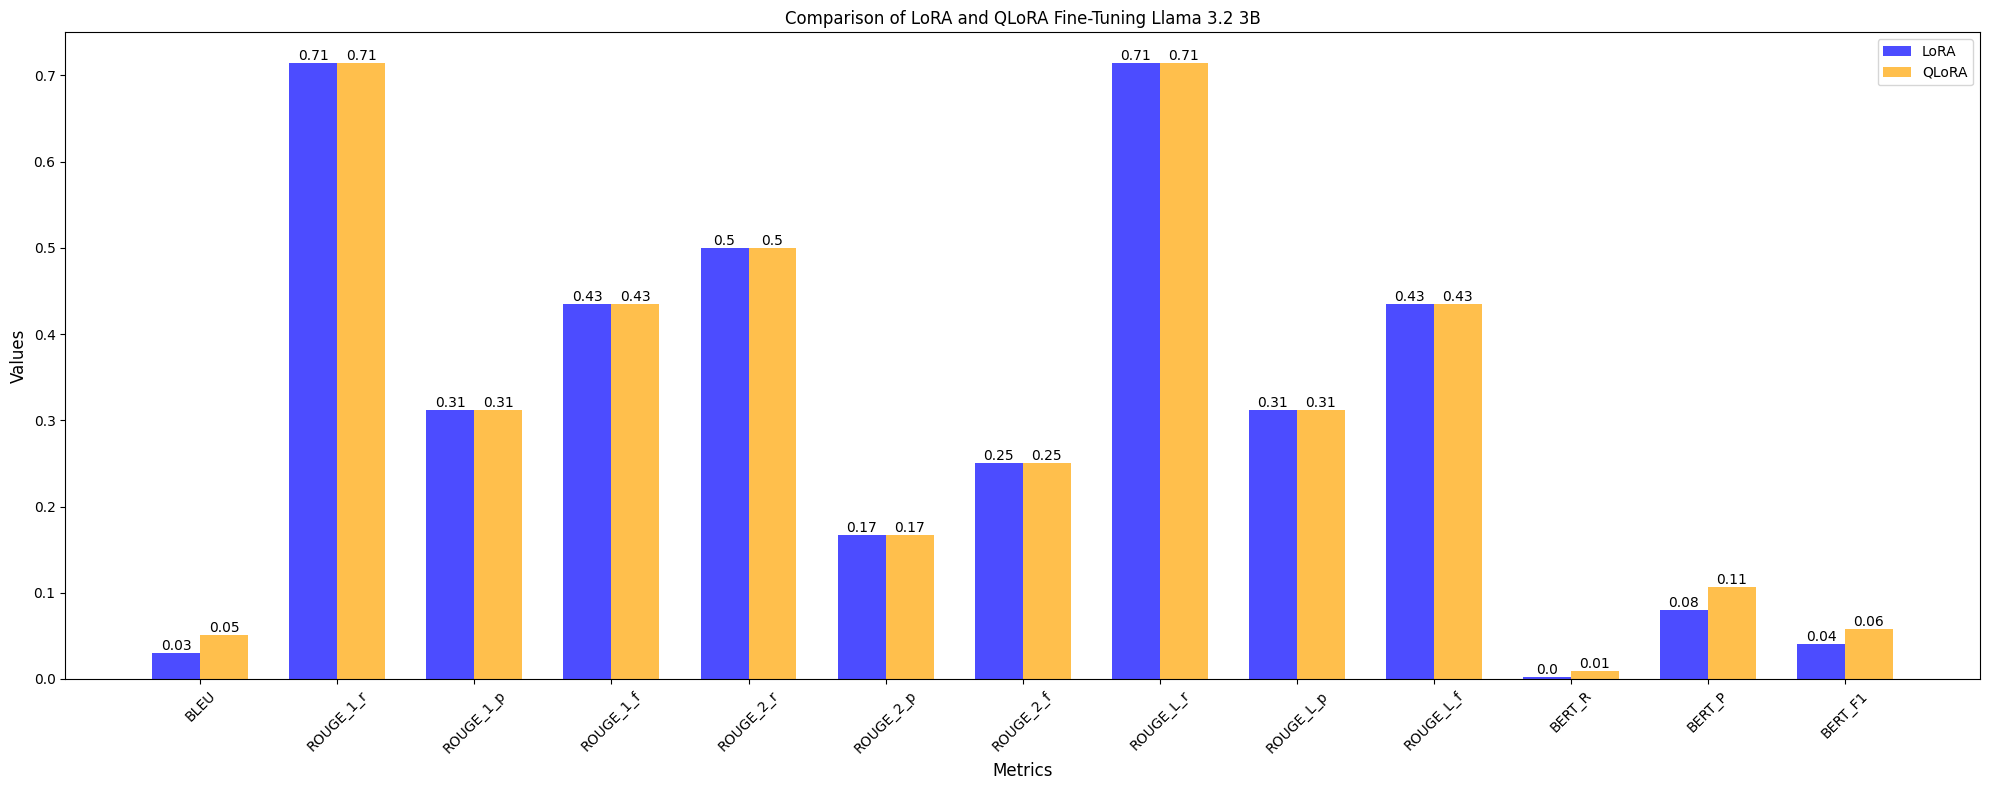

In [20]:
compare2CSV("/srv/data1/fuxiaoqin/Metrics_LM32_3B_QA_LoRA.csv", "/srv/data1/fuxiaoqin/Metrics_LM32_3B_QA_QLoRA.csv")